<a href="https://colab.research.google.com/github/yohanesnuwara/66DaysOfData/blob/main/D01_PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Principal Component Analysis

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.datasets import load_digits, fetch_lfw_people
from sklearn.preprocessing import StandardScaler

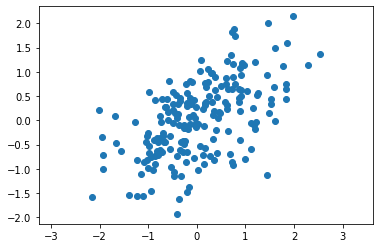

In [3]:
rng = np.random.RandomState(1)
X = np.dot(rng.rand(2, 5), rng.randn(5, 200)).T
plt.scatter(X[:, 0], X[:, 1])
plt.axis('equal')
plt.show()

In [4]:
pca = PCA(n_components=2)
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

PCA components are called eigenvectors.

In [5]:
print(pca.components_) 
print(pca.explained_variance_)

[[ 0.7866405   0.61741131]
 [ 0.61741131 -0.7866405 ]]
[1.09828586 0.29539713]


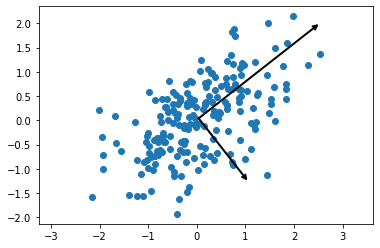

In [6]:
def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, shrinkB=0)
    ax.annotate('', v1, v0, arrowprops=arrowprops)

# plot data
plt.scatter(X[:, 0], X[:, 1])
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)
    draw_vector(pca.mean_, pca.mean_ + v)
plt.axis('equal');

## PCA to reduce dimension.

In [7]:
pca = PCA(n_components=1)
pca.fit(X)
X_pca = pca.transform(X)
print("original shape:   ", X.shape)
print("transformed shape:", X_pca.shape)

original shape:    (200, 2)
transformed shape: (200, 1)


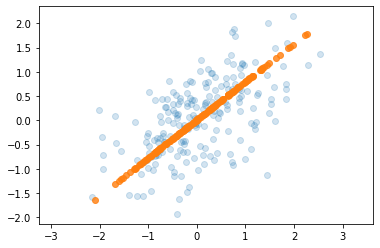

In [8]:
X_new = pca.inverse_transform(X_pca)
plt.scatter(X[:, 0], X[:, 1], alpha=0.2)
plt.scatter(X_new[:, 0], X_new[:, 1], alpha=0.8)
plt.axis('equal')
plt.show()

## PCA for digit classification. 

In [9]:
digits = load_digits()
print(digits.data.shape)

(1797, 64)


In [10]:
pca = PCA(2)  # project from 64 to 2 dimensions
projected = pca.fit_transform(digits.data)
print(digits.data.shape)
print(projected.shape)

(1797, 64)
(1797, 2)


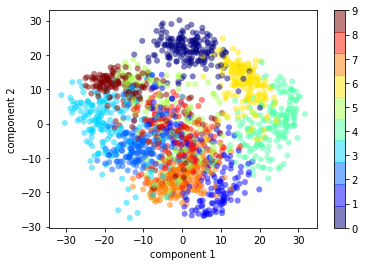

In [11]:
plt.scatter(projected[:, 0], projected[:, 1],
            c=digits.target, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('jet', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar()
plt.show()

Here, PCA can be used to approximate a digit. For instance, a 64-pixel image can be approximated by a dimensionality reduced 8-pixel image. Reconstructing using PCA as a basis function:

$$image(x)=mean+x1⋅(basis 1)+x2⋅(basis 2)+x3⋅(basis 3)⋯$$

In [12]:
def plot_pca_components(x, coefficients=None, mean=0, components=None,
                        imshape=(8, 8), n_components=8, fontsize=12,
                        show_mean=True):
    if coefficients is None:
        coefficients = x
        
    if components is None:
        components = np.eye(len(coefficients), len(x))
        
    mean = np.zeros_like(x) + mean

    fig = plt.figure(figsize=(1.2 * (5 + n_components), 1.2 * 2))
    g = plt.GridSpec(2, 4 + bool(show_mean) + n_components, hspace=0.3)

    def show(i, j, x, title=None):
        ax = fig.add_subplot(g[i, j], xticks=[], yticks=[])
        ax.imshow(x.reshape(imshape), interpolation='nearest', cmap='binary')
        if title:
            ax.set_title(title, fontsize=fontsize)

    show(slice(2), slice(2), x, "True")
    
    approx = mean.copy()
    
    counter = 2
    if show_mean:
        show(0, 2, np.zeros_like(x) + mean, r'$\mu$')
        show(1, 2, approx, r'$1 \cdot \mu$')
        counter += 1

    for i in range(n_components):
        approx = approx + coefficients[i] * components[i]
        show(0, i + counter, components[i], r'$c_{0}$'.format(i + 1))
        show(1, i + counter, approx,
             r"${0:.2f} \cdot c_{1}$".format(coefficients[i], i + 1))
        if show_mean or i > 0:
            plt.gca().text(0, 1.05, '$+$', ha='right', va='bottom',
                           transform=plt.gca().transAxes, fontsize=fontsize)

    show(slice(2), slice(-2, None), approx, "Approx")
    return fig

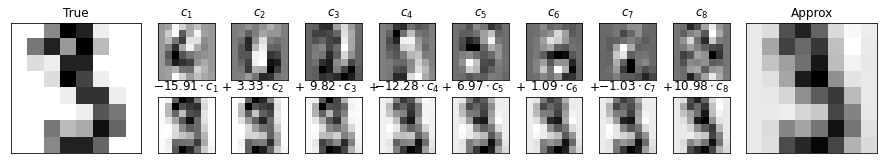

In [13]:
pca = PCA(n_components=8)
Xproj = pca.fit_transform(digits.data)

fig = plot_pca_components(digits.data[3], Xproj[3],
                          pca.mean_, pca.components_, show_mean=False)

Choose the optimum number of components. 20 is good to account over 90% of variance.

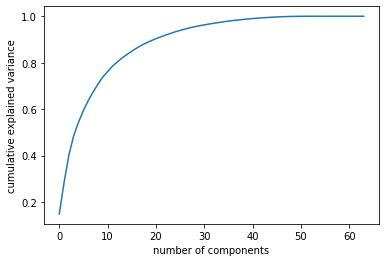

In [14]:
pca = PCA().fit(digits.data)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

## PCA for noise filtering

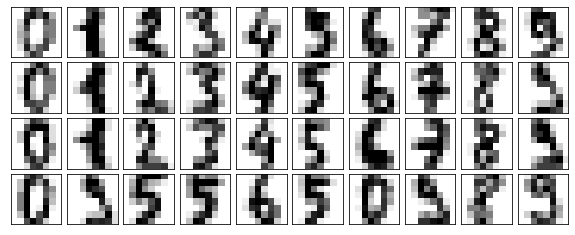

In [15]:
def plot_digits(data):
    fig, axes = plt.subplots(4, 10, figsize=(10, 4),
                             subplot_kw={'xticks':[], 'yticks':[]},
                             gridspec_kw=dict(hspace=0.1, wspace=0.1))
    for i, ax in enumerate(axes.flat):
        ax.imshow(data[i].reshape(8, 8),
                  cmap='binary', interpolation='nearest',
                  clim=(0, 16))
plot_digits(digits.data)

Add random noise.

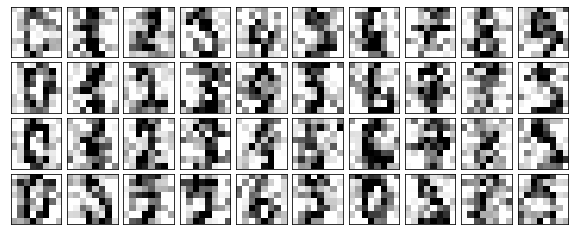

In [16]:
np.random.seed(42)
noisy = np.random.normal(digits.data, 5) # Tweak this number as level of noise
plot_digits(noisy)

Make the PCA preserve 50% of the variance. There are 12 components the most fit one.

In [17]:
pca = PCA(0.50).fit(noisy)
print(pca.n_components_)

15


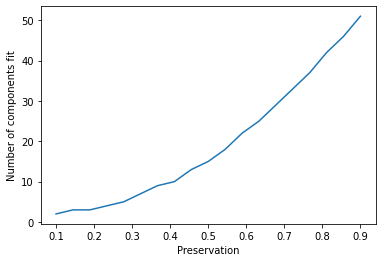

In [18]:
# See the number of components given % preservations
x = np.linspace(0.1, 0.9, 19)
comp = [(PCA(i).fit(noisy)).n_components_ for i in x]

plt.plot(x, comp)
plt.xlabel('Preservation')
plt.ylabel('Number of components fit')
plt.show()

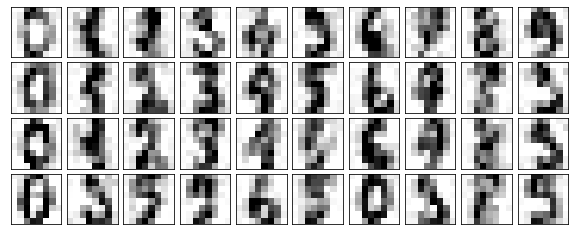

In [19]:
components = pca.transform(noisy)
filtered = pca.inverse_transform(components)
plot_digits(filtered)

## Eigenfaces

In [20]:
faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.target_names)
print(faces.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


There are 3,000 dimensions. Take a look at first 150 components.

In [21]:
pca = PCA(150)
pca.fit(faces.data)

PCA(copy=True, iterated_power='auto', n_components=150, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

Look at the first 24 components (eigenvectors or "eigenfaces").

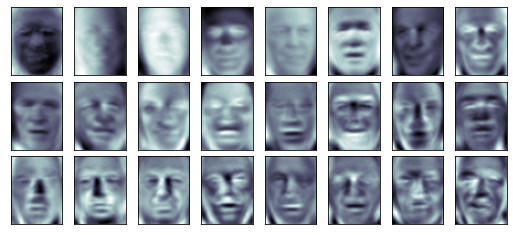

In [35]:
fig, axes = plt.subplots(3, 8, figsize=(9, 4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
  ax.imshow(pca.components_[i].reshape(62, 47), cmap='bone')

150 is good to account for 90% of variance. Using these 150 components, we would recover most of the essential characteristics of the data.

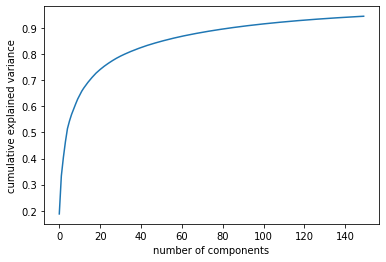

In [23]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [24]:
# Compute the components and projected faces
pca = PCA(150).fit(faces.data)
components = pca.transform(faces.data)
projected = pca.inverse_transform(components)

Reconstructing the full 3,000 pixel input image reduced to 150.

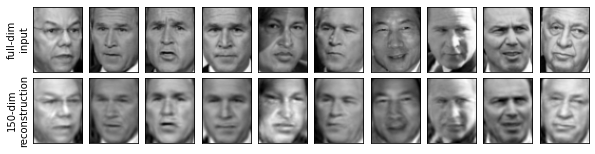

In [25]:
# Plot the results
fig, ax = plt.subplots(2, 10, figsize=(10, 2.5),
                       subplot_kw={'xticks':[], 'yticks':[]},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i in range(10):
    ax[0, i].imshow(faces.data[i].reshape(62, 47), cmap='binary_r')
    ax[1, i].imshow(projected[i].reshape(62, 47), cmap='binary_r')
    
ax[0, 0].set_ylabel('full-dim\ninput')
ax[1, 0].set_ylabel('150-dim\nreconstruction');

## Feature selection

In [52]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/'
                      'machine-learning-databases/wine/wine.data',
                      header=None)

df.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
              'Alcalinity of ash', 'Magnesium', 'Total phenols',
              'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
              'Color intensity', 'Hue',
              'OD280/OD315 of diluted wines', 'Proline']

df.head()

,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [46]:
X, y = df.iloc[:, 1:], df.iloc[:, 0]

scaler = StandardScaler()
X_std = scaler.fit_transform(X)

In [49]:
pca=PCA()

Xt = pca.fit_transform(X_std)

In [50]:
pca.explained_variance_ratio_

array([0.36198848, 0.1920749 , 0.11123631, 0.0706903 , 0.06563294,
       0.04935823, 0.04238679, 0.02680749, 0.02222153, 0.01930019,
       0.01736836, 0.01298233, 0.00795215])

From the bar plot below, 6 features are important, until it reach 90% of variance (red curve).

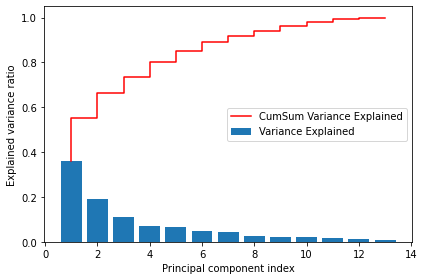

In [51]:
plt.bar(range(1,14),pca.explained_variance_ratio_,label='Variance Explained')
plt.step(range(1,14),np.cumsum(pca.explained_variance_ratio_),label='CumSum Variance Explained',c='r')

plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

References:

* https://jakevdp.github.io/PythonDataScienceHandbook/05.10-manifold-learning.html
* https://github.com/dishaaagarwal/Dimensionality-Reduction-Techniques
* Other resources:
  * https://www.ritchieng.com/machine-learning-dimensionality-reduction-feature-transform/
  * https://medium.com/analytics-vidhya/implementing-pca-in-python-with-sklearn-4f757fb4429e